✨ Detector y Segmentador de Placas ✨
Archivos disponibles: 01, 04, 05, 06, 07, 08, 09

--- PASO 1: DETECCIÓN Y CORRECCIÓN ---
🧭 Ángulo detectado: -3.30°
✅ Placa detectada y recortada.

--- PASO 2: SEGMENTACIÓN DE CARACTERES ---
✅ Método seleccionado: Normal (6 caracteres)
💾 6 caracteres guardados en 'chars'.

--- PASO 3: VISUALIZACIÓN DE RESULTADOS ---
1. Detección de Placa:


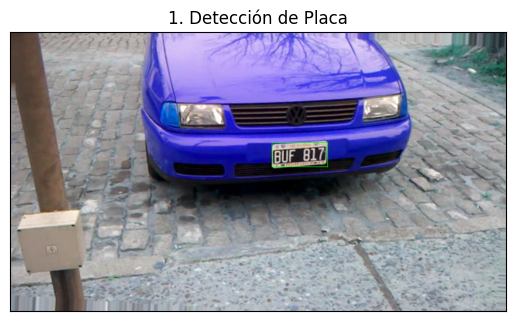

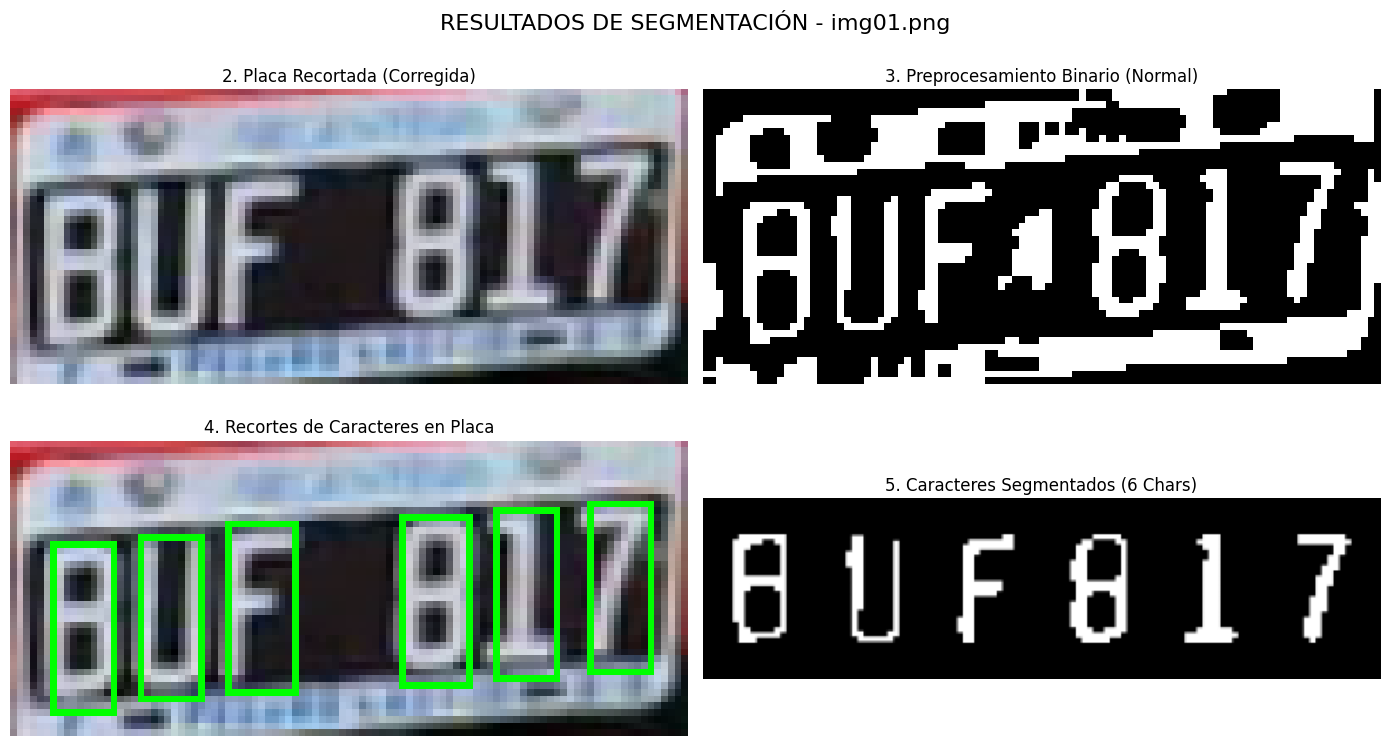


✨ PROCESAMIENTO COMPLETO Y TERMINADO ✨


In [ ]:
import cv2
import numpy as np
import imutils
import matplotlib.pyplot as plt
import os
import sys

# ============================================================
# LISTADO DE IMÁGENES PERMITIDAS
# ============================================================
NUMEROS_PERMITIDOS = ['01', '04', '05', '06', '07', '08', '09']

# Defininimos función para mostrar imágenes
def imshow(img, title=None, color_img=False, blocking=False):
    plt.figure()
    if color_img:
        plt.imshow(img)
    else:
        plt.imshow(img, cmap='gray')
    plt.title(title)
    plt.xticks([]), plt.yticks([])
    plt.show(block=blocking)


# ============================================================
# FUNCIONES DE DETECCIÓN (CÓDIGO 1)
# ============================================================

def detectar_placa_basico(img):
    """Detección original que busca un contorno de 4 lados con la proporción de placa."""
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    blur = cv2.bilateralFilter(gray, 11, 17, 17)
    edged = cv2.Canny(blur, 30, 200)
    cnts = cv2.findContours(edged.copy(), cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    cnts = imutils.grab_contours(cnts)
    cnts = sorted(cnts, key=cv2.contourArea, reverse=True)[:30]
    placa = None
    img_copia = img.copy()

    for c in cnts:
        peri = cv2.arcLength(c, True)
        approx = cv2.approxPolyDP(c, 0.018 * peri, True)
        if len(approx) == 4:
            x, y, w, h = cv2.boundingRect(approx)
            ratio = w / float(h)
            if 2 < ratio < 5 and 1000 < w * h < 50000:
                cv2.rectangle(img_copia, (x, y), (x + w, y + h), (0, 255, 0), 1)
                placa = img[y:y + h, x:x + w]
                break

    return img_copia, placa


def detectar_placa_fallback(img):
    """Modo de rescate: Busca contornos en una ROI inferior-central con filtros de proporción."""
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    blur = cv2.bilateralFilter(gray, 11, 17, 17)

    # Región de Interés (ROI)
    h, w = gray.shape
    roi_start_y = int(h * 0.55)
    roi_start_x = int(w * 0.2)
    roi = blur[roi_start_y:int(h * 0.95), roi_start_x:int(w * 0.8)]

    edges = cv2.Canny(roi, 20, 180)
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (5, 5))
    closed = cv2.morphologyEx(edges, cv2.MORPH_CLOSE, kernel)

    cnts = cv2.findContours(closed, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    cnts = imutils.grab_contours(cnts)

    placa = None
    img_copia = img.copy()

    for c in sorted(cnts, key=cv2.contourArea, reverse=True):
        x_c, y_c, w_c, h_c = cv2.boundingRect(c) # Coordenadas relativas a la ROI

        ratio = w_c / float(h_c)
        area = w_c * h_c

        if 1.8 < ratio < 2.7 and 1000 < area < 40000:
            # Coordenadas absolutas ajustadas por la ROI
            x_abs = x_c + roi_start_x
            y_abs = y_c + roi_start_y

            # Dibujar el rectángulo
            cv2.rectangle(img_copia, (x_abs, y_abs), (x_abs + w_c, y_abs + h_c), (0, 255, 255), 2)

            # Recortar la placa
            placa = img[y_abs:y_abs + h_c, x_abs:x_abs + w_c]
            break

    return img_copia, placa


# ============================================================
# FUNCIONES DE SEGMENTACIÓN (CÓDIGO 2)
# ============================================================

def overlap(a, b):
    """Calcula si hay solapamiento significativo entre dos bounding boxes."""
    x1, y1, w1, h1 = a
    x2, y2, w2, h2 = b
    dx = min(x1+w1, x2+w2) - max(x1, x2)
    dy = min(y1+h1, y2+h2) - max(y1, y2)
    if dx <= 0 or dy <= 0:
        return False
    inter = dx * dy
    union = w1*h1 + w2*w2 - inter
    return inter / union > 0.2


def segmentar_placa(img_corr, usar_inversion=False):
    """
    Realiza el preprocesamiento y la segmentación de contornos.
    Retorna (imagen_procesada, lista_caracteres).
    """
    gray = cv2.cvtColor(img_corr, cv2.COLOR_BGR2GRAY)
    h_img, w_img = gray.shape

    # --- PASO 1: Preprocesamiento Agresivo (CLAHE) ---
    clahe = cv2.createCLAHE(clipLimit=4.0, tileGridSize=(4,4))
    gray_clahe = clahe.apply(gray)

    if usar_inversion:
        gray_clahe = cv2.bitwise_not(gray_clahe)

    gray_blur = cv2.bilateralFilter(gray_clahe, 9, 75, 75)

    # --- PASO 2: Umbralización Adaptativa (Puro) ---
    thresh = cv2.adaptiveThreshold(
        gray_blur, 255,
        cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
        cv2.THRESH_BINARY,
        15, 3
    )

    # --- PASO 3: Morfología de Separación (Erosión + Dilatación) ---
    kernel_erode = cv2.getStructuringElement(cv2.MORPH_RECT, (2,2))
    morph = cv2.erode(thresh, kernel_erode, iterations=1)

    kernel_dilate = cv2.getStructuringElement(cv2.MORPH_RECT, (1,1))
    morph = cv2.dilate(morph, kernel_dilate, iterations=1)

    # --- PASO 4: Detección de Contornos (Filtros Relajados + FILTRO CENTRAL) ---
    contours, _ = cv2.findContours(morph, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # Parámetros de filtrado (Relajados)
    min_h = h_img * 0.25
    max_h = h_img * 0.95
    min_w = w_img * 0.01
    max_w = w_img * 0.4
    min_aspect = 0.1
    max_aspect = 4.0
    min_area = 50

    # Zona Central Prohibida
    centro_x = w_img / 2
    MARGEN_CENTRAL = 0.05
    x_min_prohibida = int(centro_x - w_img * MARGEN_CENTRAL)
    x_max_prohibida = int(centro_x + w_img * MARGEN_CENTRAL)

    candidatos = []

    for c in contours:
        x, y, w, h = cv2.boundingRect(c)
        aspect = w / float(h)
        area = w * h

        es_valido_geometrico = (
            min_aspect < aspect < max_aspect and
            min_w < w < max_w and
            min_h < h < max_h and
            area > min_area
        )

        es_central = x < x_max_prohibida and (x + w) > x_min_prohibida

        if es_valido_geometrico and not es_central:
            candidatos.append((x, y, w, h))

    # --- PASO 5: Post-procesamiento de Candidatos ---
    candidatos = sorted(candidatos, key=lambda c: c[0])

    chars = []
    for c in candidatos:
        if not any(overlap(c, c2) for c2 in chars):
            chars.append(c)

    if len(chars) > 7:
        chars = sorted(chars, key=lambda c: c[2]*c[3], reverse=True)[:7]
        chars = sorted(chars, key=lambda c: c[0])

    return morph, chars


# ============================================================
# MAIN FUSIONADO E INTERACTIVO
# ============================================================

if __name__ == "__main__":
    # --- CONFIGURACIÓN DE RUTAS ---
    UMBRAL_ANGULO = 10
    os.makedirs("placas_detectadas", exist_ok=True)
    os.makedirs("chars", exist_ok=True)

    # 1. SOLICITAR IMAGEN AL USUARIO
    print("==================================================")
    print("✨ Detector y Segmentador de Placas ✨")
    print(f"Archivos disponibles: {', '.join(NUMEROS_PERMITIDOS)}")
    print("==================================================")

    num_str = input("👉 Ingresa el número de imagen (ej: 01, 04, 09) o 'salir': ").strip()

    if num_str.lower() == 'salir':
        print("👋 Programa terminado.")
        sys.exit()

    # Formateo si se ingresa '1' en lugar de '01'
    if len(num_str) == 1 and num_str.isdigit():
        num_str = "0" + num_str

    if num_str not in NUMEROS_PERMITIDOS:
        print(f"❌ Error: El número '{num_str}' no es una opción válida.")
        sys.exit()

    RUTA_IMAGEN = f'img{num_str}.png'

    if not os.path.exists(RUTA_IMAGEN):
        print(f"❌ Error: El archivo '{RUTA_IMAGEN}' no existe. Terminando.")
        sys.exit()

    nombre_base = os.path.splitext(RUTA_IMAGEN)[0]

    # ----------------------------------------------------
    # I. DETECCIÓN DE PLACA Y CORRECCIÓN DE INCLINACIÓN
    # ----------------------------------------------------

    print("\n--- PASO 1: DETECCIÓN Y CORRECCIÓN ---")

    img = cv2.imread(RUTA_IMAGEN)
    img = imutils.resize(img, width=900)

    # 1. Corrección de Inclinación (Se aplica a la imagen COMPLETA antes de la detección)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    blur_deskew = cv2.GaussianBlur(gray, (5, 5), 0)
    edges = cv2.Canny(blur_deskew, 50, 150, apertureSize=3)

    lines = cv2.HoughLinesP(edges, 1, np.pi / 180, threshold=50, minLineLength=30, maxLineGap=10)
    angulos = []

    if lines is not None:
        for line in lines:
            x1, y1, x2, y2 = line[0]
            ang = np.degrees(np.arctan2(y2 - y1, x2 - x1))
            if -UMBRAL_ANGULO < ang < UMBRAL_ANGULO:
                angulos.append(ang)

    angulo_prom = np.median(angulos) if len(angulos) > 0 else 0
    (h, w) = img.shape[:2]
    M = cv2.getRotationMatrix2D((w // 2, h // 2), angulo_prom, 1.0)
    img_corr_completa = cv2.warpAffine(img, M, (w, h), flags=cv2.INTER_CUBIC, borderMode=cv2.BORDER_REPLICATE)

    print(f"🧭 Ángulo detectado: {angulo_prom:.2f}°")

    # 2. Detección de Placa (sobre la imagen corregida)
    img_det, placa = detectar_placa_basico(img_corr_completa)

    if placa is None:
        img_det, placa = detectar_placa_fallback(img_corr_completa)

    if placa is None:
        print("❌ Fallo total: No se detectó ninguna placa.")
        imshow(img_corr_completa, title='Original', color_img=True, blocking=True)
        sys.exit()

    print("✅ Placa detectada y recortada.")

    # ----------------------------------------------------
    # II. SEGMENTACIÓN DE CARACTERES EN LA PLACA RECORTADA
    # ----------------------------------------------------

    print("\n--- PASO 2: SEGMENTACIÓN DE CARACTERES ---")

    # 1. Selección del mejor método de segmentación
    morph1, chars1 = segmentar_placa(placa, usar_inversion=False)
    morph2, chars2 = segmentar_placa(placa, usar_inversion=True)

    mejor_chars = chars1
    mejor_morph = morph1
    mejor_metodo = "Normal"

    if abs(len(chars2) - 6.5) < abs(len(chars1) - 6.5):
        mejor_chars = chars2
        mejor_morph = morph2
        mejor_metodo = "Inversión"

    print(f"✅ Método seleccionado: {mejor_metodo} ({len(mejor_chars)} caracteres)")

    # 2. Dibujo, Recorte y Guardado de Caracteres
    img_out = placa.copy()
    PORCENTAJE_EXPANSION_VERTICAL = 0.20
    REDUCCION_HORIZONTAL = 0.10
    caracteres_recortados = []

    for i, (x, y, w, h) in enumerate(mejor_chars):
        # Aplicar ajustes de bounding box
        h_expansion = int(h * PORCENTAJE_EXPANSION_VERTICAL)
        y_ajustada = max(0, y - int(h_expansion / 2))
        h_ajustada = h + h_expansion

        w_reduccion = int(w * REDUCCION_HORIZONTAL)
        x_ajustada = max(0, x + int(w_reduccion / 2))
        w_ajustado = w - w_reduccion

        # Recorte (Verificación de límites)
        y_final = min(placa.shape[0], y_ajustada + h_ajustada)
        x_final = min(placa.shape[1], x_ajustada + w_ajustado)

        # Dibujar rectángulo en la placa recortada
        cv2.rectangle(img_out, (x_ajustada, y_ajustada), (x_final, y_final), (0, 255, 0), 1)

        # Extraer y guardar el caracter del MORPH (binario)
        char_crop = mejor_morph[y_ajustada:y_final, x_ajustada:x_final]
        pad = 5
        char_padded = cv2.copyMakeBorder(char_crop, pad, pad, pad, pad, cv2.BORDER_CONSTANT, value=0)

        cv2.imwrite(f"chars/{nombre_base}_char_{i+1}.png", char_padded)
        caracteres_recortados.append(char_padded)

    print(f"💾 {len(mejor_chars)} caracteres guardados en 'chars'.")

    # ----------------------------------------------------
    # III. VISUALIZACIÓN DE RESULTADOS
    # ----------------------------------------------------

    print("\n--- PASO 3: VISUALIZACIÓN DE RESULTADOS ---")

    # A. Detección de Placa
    print("1. Detección de Placa:")
    imshow(img_det, title=f'1. Detección de Placa {num_str}', color_img=True, blocking=True)

    # B. Segmentación de Caracteres (Matplotlib)
    fig, axes = plt.subplots(2, 2, figsize=(14, 8))
    fig.suptitle(f"RESULTADOS DE SEGMENTACIÓN - {RUTA_IMAGEN}", fontsize=16)

    axes[0, 0].imshow(cv2.cvtColor(placa, cv2.COLOR_BGR2RGB))
    axes[0, 0].set_title(f"2. Placa {num_str} Recortada (Corregida)")
    axes[0, 0].axis("off")

    axes[0, 1].imshow(mejor_morph, cmap='gray')
    axes[0, 1].set_title(f"3. Placa {num_str} Preprocesamiento Binario ({mejor_metodo})")
    axes[0, 1].axis("off")

    axes[1, 0].imshow(cv2.cvtColor(img_out, cv2.COLOR_BGR2RGB))
    axes[1, 0].set_title(f"4. Recortes de Caracteres en Placa {num_str}")
    axes[1, 0].axis("off")

    if caracteres_recortados:
        chars_resized = [cv2.resize(char, (50, 80), interpolation=cv2.INTER_AREA) for char in caracteres_recortados]
        chars_display = np.hstack(chars_resized)
        axes[1, 1].imshow(chars_display, cmap='gray')
        axes[1, 1].set_title(f"5. Placa {num_str} con Caracteres Segmentados ({len(mejor_chars)} Chars)")
        axes[1, 1].axis("off")
    else:
         axes[1, 1].set_title(f"5. No se detectaron caracteres para mostrar en placa {num_str}")
         axes[1, 1].axis("off")

    plt.tight_layout()
    plt.show()

    print("\n==============================================")
    print("✨ PROCESAMIENTO COMPLETO Y TERMINADO ✨")
    print("==============================================")